this is the initial test for interacting with the blackjack env in the gym library, just so we understand how the environment works b4 we move on to making the logic for the agent

To test it, install the libraries in the requirements.txt file and try running the box below. If you have issues  w installation (i had a few), just ask chatgpt and it will help. i needed to install a lib called swig. 


##  TODO

1. Change blackjack gym env (lines 178-181 in blackjack.py) in order to print which cards dealer draws after player stays (just for info/debugging, kind of wierd they didn't already implement that)
2. Instead of interacting via keyboard, we will be training an agent to decide what to do (RL learning, where agent will be rewarded/punished for winning/losing rounds)
3. add more functionality to blackjack env such as:
    - Splitting cards
    - Doubling down

3. We also need to come up with some benchmark comparisons, such as randomly choosing hit/stay, and see how that does compared to a slightly better strategy, and finally compared to our agent/agents 

4. If time allows, we should completely change how the env works. right now, it simply picks a card at random with replacement, so there is no accurate model checking which cards have already been played, and there is no logic for 'shuffling' the deck after a certain amount of rounds



In [12]:
import gymnasium as gym

# Initialize the Blackjack environment with support for action 'sab'
env = gym.make("Blackjack-v1", sab=True)

def play_blackjack():
    # Start a new game
    observation,_ = env.reset()
    player_hand, dealer_hand, usable_ace = observation
    print(f"Your initial hand: {player_hand}, Dealer's initial card: {dealer_hand}, Usable ace: {usable_ace}")
    
    while True:
        # Ask the user for their action
        action = input("Do you want to hit (1) or stay (0)? ")
        try:
            action = int(action)
            if action not in [0, 1]:
                raise ValueError
        except ValueError:
            print("Invalid input. Please enter 1 (hit) or 0 (stay).")
            continue

        # Take the action in the environment
        observation, reward, terminated, truncated, info = env.step(action)
        player_hand, dealer_hand, usable_ace = observation

        print(f"After action: Your hand: {player_hand}, Usable ace: {usable_ace}")

        if terminated or action == 0:  # Player busts, wins, draws, or decides to stay
            print(f"Final outcome: Your hand: {player_hand}")
            if terminated:
                if reward > 0:
                    print("You won!")
                elif reward < 0:
                    print("You lost!")
                else:
                    print("It's a draw!")
            break

# Play one round of Blackjack
play_blackjack()



Your initial hand: 16, Dealer's initial card: 10, Usable ace: 0
After action: Your hand: 16, Usable ace: 0
Final outcome: Your hand: 16
You lost!


In [2]:
import gymnasium as gym
import pandas as pd

# Initialize the Blackjack environment with support for action 'sab'
env = gym.make("Blackjack-v1", sab=True)

data = []

def collect_blackjack_data(num_rounds):
    for _ in range(num_rounds):
        observation, _ = env.reset()
        player_hand, dealer_hand, usable_ace = observation
        terminated = False

        while not terminated:
            # Here, you'd replace the random action with the actual decision-making process (user or strategy)
            action = env.action_space.sample()  # For simplicity, using a random action
            next_observation, reward, terminated, truncated, _ = env.step(action)
            next_player_hand, _, _ = next_observation

            # Record the decision point
            data.append({
                'Player Hand': player_hand,
                'Dealer Hand': dealer_hand,
                'Usable Ace': usable_ace,
                'Action': action,
                'Next Player Hand': next_player_hand,
                'Reward': reward,
                'Terminated': terminated
            })

            # Update current state
            player_hand, dealer_hand, usable_ace = next_observation

# Example usage
collect_blackjack_data(1000)  # Collect data from 1000 rounds

# Convert to DataFrame
df = pd.DataFrame(data)

# Processing the DataFrame to align outcomes might be necessary based on your analysis needs.


In [6]:
df.head(100)

,Player Hand,Dealer Hand,Usable Ace,Action,Next Player Hand,Reward,Terminated
0,16,9,0,1,20,0.0,False
1,20,9,0,0,20,1.0,True
2,14,6,0,0,14,1.0,True
3,6,10,0,1,12,0.0,False
4,12,10,0,1,14,0.0,False
...,...,...,...,...,...,...,...
95,19,10,0,1,25,-1.0,True
96,7,6,0,1,10,0.0,False
97,10,6,0,0,10,-1.0,True
98,19,10,0,1,22,-1.0,True


In [9]:
import gymnasium as gym
import numpy as np

# Initialize the Blackjack environment
env = gym.make("Blackjack-v1", sab=True)

def q_learning_blackjack(episodes):
    # Q-values: Player sum (12-21), Dealer card (1-10), Usable ace (True/False), Action (0, 1)
    q_values = np.zeros((10, 10, 2, 2))  # Simplified to focus on sums 12-21 for the player
    learning_rate = 0.01
    discount_factor = 0.8  # Since the game is episodic
    epsilon = 0.1  # Exploration rate

    for _ in range(episodes):
        observation,_ = env.reset()  # Start a new game
        while True:
            player_hand, dealer_card, usable_ace = observation
            if np.random.rand() < epsilon:  # Explore
                action = env.action_space.sample()
            else:  # Exploit
                action = np.argmax(q_values[player_hand-12][dealer_card-1][int(usable_ace)])
            
            # Take action and observe the outcome
            new_observation, reward, d1, _ , _= env.step(action)
            new_player_hand, new_dealer_card, new_usable_ace = new_observation

            # Update Q-values
            if not done:
                next_best_action = np.argmax(q_values[new_player_hand-12][new_dealer_card-1][int(new_usable_ace)])
                target = reward + discount_factor * q_values[new_player_hand-12][new_dealer_card-1][int(new_usable_ace)][next_best_action]
            else:
                target = reward  # End of episode
            
            q_values[player_hand-12][dealer_card-1][int(usable_ace)][action] += learning_rate * (target - q_values[player_hand-12][dealer_card-1][int(usable_ace)][action])
            
            if done:
                break
            observation = new_observation
    
    return q_values

def find_optimal_policy(q_values):
    optimal_policy = np.zeros((10, 10, 2), dtype=int)
    for player_hand in range(10):
        for dealer_card in range(10):
            for usable_ace in range(2):
                optimal_policy[player_hand][dealer_card][usable_ace] = np.argmax(q_values[player_hand][dealer_card][usable_ace])
    return optimal_policy

# Training
episodes = 100000
q_values = q_learning_blackjack(episodes)
optimal_policy = find_optimal_policy(q_values)

# The optimal_policy array now contains the best action (0 or 1) for each state


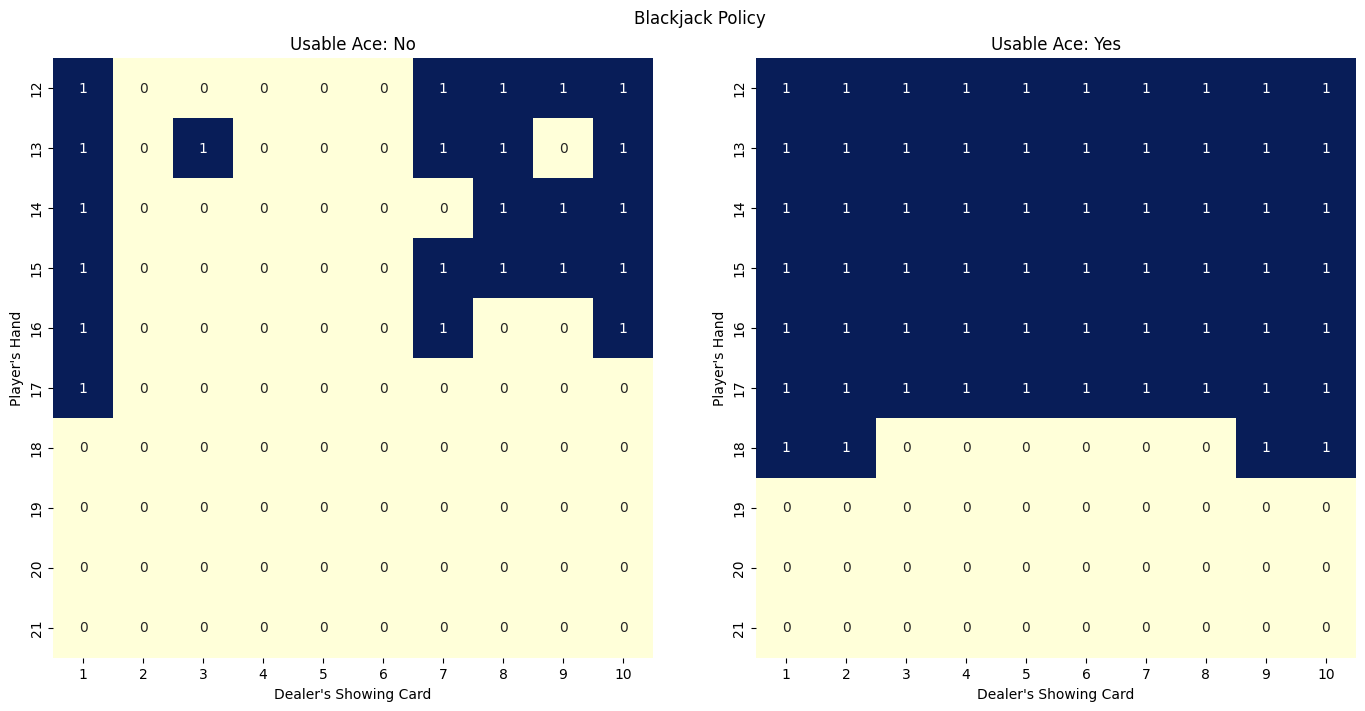

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_policy(policy, title='Blackjack Policy'):
    """
    Visualizes the Blackjack policy.
    
    Parameters:
        policy (np.array): The policy to visualize, with shape (10, 10, 2), where the dimensions are
                           player's hand (12-21), dealer's showing card (1-10), and usable ace (0, 1).
        title (str): The title for the plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), constrained_layout=True)

    for i, ax in enumerate(axes):
        sns.heatmap(policy[:, :, i], cmap="YlGnBu", ax=ax, square=True,
                    annot=True, cbar=False, fmt="d",
                    xticklabels=range(1, 11), yticklabels=range(12, 22))
        ax.set_title(f"Usable Ace: {'Yes' if i == 1 else 'No'}")
        ax.set_xlabel("Dealer's Showing Card")
        ax.set_ylabel("Player's Hand")
    
    plt.suptitle(title)
    plt.show()

# Assuming 'optimal_policy' is your calculated policy from Q-learning
# Remember to adjust this line according to how your policy array is structured
visualize_policy(optimal_policy)
